# Discharge Notes and Readmission Rates: Additional Features

In this notebook, I took the text data that has been processed through vectorizer and models from the NLP notebook, merged with other patient data features, and ran the data again through models to see if if I can get better scores than just with the text data. Please see the following for the other notebooks:
* [EDA Notebook](01_EDA.ipynb)
* [NLP Modeling Notebook](02_Modeling_NLP.ipynb)

## Import

Import the relevant libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#vectorizers
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, recall_score, plot_confusion_matrix
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
#import xgboost as xg
from sklearn.pipeline import Pipeline 
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.utils import class_weight

## Functions

This section is for any functions created for the analysis.

In [2]:
def scores(model, X, y, set_type, return_conf=False):
    '''
    This function takes in an already fitted model, X, y, and
    the type of data (train, validation, or test) in str format,
    and prints out the accuracy and recall scores. The function
    also prints out the confusion matrix
    '''
    pred = model.predict(X)
    acc_score = accuracy_score(y, pred)
    rec_score = recall_score(y, pred)
    
    print("{} Scores".format(set_type))
    print("accuracy: ", acc_score)
    print("recall:   ", rec_score)
    fig, ax = plt.subplots(figsize=(6,6))
    #set background color to white
    fig.patch.set_facecolor('white')
    ax.set_title(set_type)
    plot_confusion_matrix(model, X, y, ax=ax)
    if return_conf == True:
        return fig, round(acc_score*100,1), round(rec_score*100,1)
    if return_conf == False:
        return round(acc_score*100,1), round(rec_score*100,1)

## Reading in the Data

Here, I read in the dataset with the NLP processed text data and the other patient data features. The first dataframe (df1) is with the predicted classification (0 no readmission or 1 readmission) in the TEXT column. The second dataframe (df1) is with the predicted probabilities of classes in the TEXT column.

In [3]:
df1 = pd.read_csv("data/admissions_nlp_processed_1.csv.gz", compression='gzip')

In [4]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52726 entries, 0 to 52725
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ADMISSION_TYPE      52726 non-null  object
 1   ADMISSION_LOCATION  52726 non-null  object
 2   DISCHARGE_LOCATION  52726 non-null  object
 3   INSURANCE           52726 non-null  object
 4   LANGUAGE            52726 non-null  object
 5   RELIGION            52726 non-null  object
 6   MARITAL_STATUS      52726 non-null  object
 7   ETHNICITY           52726 non-null  object
 8   DIAGNOSIS           52726 non-null  object
 9   READMISSION         52726 non-null  int64 
 10  GENDER              52726 non-null  object
 11  AGE                 52726 non-null  int64 
 12  CPT_CD              52726 non-null  object
 13  DIAG_ICD9_CODE      52722 non-null  object
 14  DRG_CODE            52726 non-null  object
 15  PROCED_ICD9_CODE    52726 non-null  object
 16  TEXT                52

In [5]:
#originally had planned to break codes out, but the models were running too long, therefore had to drop code columns
df1.drop(['DIAG_ICD9_CODE','DRG_CODE', 'PROCED_ICD9_CODE'], axis=1, inplace=True)

In [6]:
df1['TEXT'].head()

0    1
1    0
2    0
3    0
4    1
Name: TEXT, dtype: int64

In [7]:
#set X as the text data, and y as the readmission status
X1 = df1.drop('READMISSION', axis=1)
y1 = df1['READMISSION']

In [8]:
df2 = pd.read_csv("data/admissions_nlp_processed_2.csv.gz", compression='gzip')

In [9]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52726 entries, 0 to 52725
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ADMISSION_TYPE      52726 non-null  object 
 1   ADMISSION_LOCATION  52726 non-null  object 
 2   DISCHARGE_LOCATION  52726 non-null  object 
 3   INSURANCE           52726 non-null  object 
 4   LANGUAGE            52726 non-null  object 
 5   RELIGION            52726 non-null  object 
 6   MARITAL_STATUS      52726 non-null  object 
 7   ETHNICITY           52726 non-null  object 
 8   DIAGNOSIS           52726 non-null  object 
 9   READMISSION         52726 non-null  int64  
 10  GENDER              52726 non-null  object 
 11  AGE                 52726 non-null  int64  
 12  CPT_CD              52726 non-null  object 
 13  DIAG_ICD9_CODE      52722 non-null  object 
 14  DRG_CODE            52726 non-null  object 
 15  PROCED_ICD9_CODE    52726 non-null  object 
 16  TEXT

In [10]:
#originally had planned to break codes out, but the models were running too long, therefore had to drop code columns
df2.drop(['DIAG_ICD9_CODE','DRG_CODE', 'PROCED_ICD9_CODE'], axis=1, inplace=True)

In [11]:
df2['TEXT'].head()

0    0.551149
1    0.367082
2    0.402644
3    0.282630
4    0.544221
Name: TEXT, dtype: float64

In [12]:
df2['READMISSION'].value_counts()

0    49715
1     3011
Name: READMISSION, dtype: int64

In [13]:
#set X as the text data, and y as the readmission status
X2 = df2.drop('READMISSION', axis=1)
y2 = df2['READMISSION']

## Train, Validation, and Test Split

Here I split both dataframes into train, validation, and test sets.

In [14]:
X_train1, X_v_t1, y_train1, y_v_t1 = train_test_split(X1, y1, test_size=0.30, random_state=42, stratify=y1)

In [15]:
X_val1, X_test1, y_val1, y_test1 = train_test_split(X_v_t1, y_v_t1, test_size=0.50, random_state=42, stratify=y_v_t1)

In [16]:
X_train1.shape

(36908, 13)

In [17]:
X_train2, X_v_t2, y_train2, y_v_t2 = train_test_split(X2, y2, test_size=0.30, random_state=42, stratify=y2)

In [18]:
X_val2, X_test2, y_val2, y_test2 = train_test_split(X_v_t2, y_v_t2, test_size=0.50, random_state=42, stratify=y_v_t2)

In [19]:
X_train2.shape

(36908, 13)

## Handling Imbalanced Data 

Just as I had to handle the imbalanced classes in the previous notebook on NLP, I used the undersampling method to mitigate the impacts of the imbalanced classes.

In [20]:
#concat the train dataset together
train_df = pd.concat([y_train1, X_train1], axis=1)

In [21]:
#split the positive and negative data
train_df_pos = train_df[train_df['READMISSION']==1]
train_df_neg = train_df[train_df['READMISSION']==0]

In [22]:
#take a sample of the negative training set with the same number of rows as positive dataset
train_df_neg_samp = train_df_neg.sample(n=len(train_df_pos), random_state=42)

In [23]:
#concat the positive dataset and sample of the negative dataset to get one dataset
#with equal number of postiive and negative cases
new_train_df = pd.concat([train_df_pos,train_df_neg_samp],axis=0)

In [24]:
#randomize the new dataset
new_train_df = new_train_df.sample(n=len(new_train_df), random_state=42)

In [25]:
#split out the X and y of the new dataset
y_train1 = new_train_df['READMISSION']
X_train1 = new_train_df.drop('READMISSION', axis=1)
max_feats_1 = int(X_train1.shape[0]*0.10)

In [26]:
#concat the train dataset together
train_df = pd.concat([y_train2, X_train2], axis=1)

In [27]:
#split the positive and negative data
train_df_pos = train_df[train_df['READMISSION']==1]
train_df_neg = train_df[train_df['READMISSION']==0]

In [28]:
#take a sample of the negative training set with the same number of rows as positive dataset
train_df_neg_samp = train_df_neg.sample(n=len(train_df_pos), random_state=42)

In [29]:
#concat the positive dataset and sample of the negative dataset to get one dataset
#with equal number of postiive and negative cases
new_train_df = pd.concat([train_df_pos,train_df_neg_samp],axis=0)

In [30]:
#randomize the new dataset
new_train_df = new_train_df.sample(n=len(new_train_df), random_state=42)

In [31]:
#split out the X and y of the new dataset
y_train2 = new_train_df['READMISSION']
X_train2 = new_train_df.drop('READMISSION', axis=1)
max_feats_2 = int(X_train2.shape[0]*0.10)

## Pipeline Parameters

In this section, I set specific pipeline parameters that I will keep constant throughout the project.

In [32]:
X_train1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4216 entries, 35763 to 6932
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ADMISSION_TYPE      4216 non-null   object
 1   ADMISSION_LOCATION  4216 non-null   object
 2   DISCHARGE_LOCATION  4216 non-null   object
 3   INSURANCE           4216 non-null   object
 4   LANGUAGE            4216 non-null   object
 5   RELIGION            4216 non-null   object
 6   MARITAL_STATUS      4216 non-null   object
 7   ETHNICITY           4216 non-null   object
 8   DIAGNOSIS           4216 non-null   object
 9   GENDER              4216 non-null   object
 10  AGE                 4216 non-null   int64 
 11  CPT_CD              4216 non-null   object
 12  TEXT                4216 non-null   int64 
dtypes: int64(2), object(11)
memory usage: 461.1+ KB


The first dataframe has the text data in categorical form 0 and 1, while the second dataframe has the text data as probabilities ranging from 0 to 1. Therefore, for the first dataframe, I considered text data as categorical, while the second dataframe, I considered the text data as numeric.

In [33]:
#set the numeric and categorical columns
X_num1 = ['AGE']
X_num2 = ['AGE', 'TEXT']
X_cat1 = df1.drop(['AGE', 'READMISSION'], axis=1).columns
X_cat2 = df2.drop(['AGE', 'READMISSION', 'TEXT'], axis=1).columns

In [34]:
#set up the column transfomer part of the pipeline
numTrans = Pipeline(steps=[
    ('scaler', StandardScaler())
    ])
catTrans = Pipeline(steps=[
    ('ohe', OneHotEncoder(sparse=False,
                          handle_unknown='ignore'))
    ])

c_transform1 = ColumnTransformer(transformers=[
    ('num', numTrans, X_num1),
    ('cat', catTrans, X_cat1)
    ])

c_transform2 = ColumnTransformer(transformers=[
    ('num', numTrans, X_num2),
    ('cat', catTrans, X_cat2)
    ])

## Modeling

### Model 0: Dummy Classification

For my Model 0, I run a simple dummy classifier.

In [35]:
#instatiate the pipeline with column transformer, PCA, and dummy classifier model
#first dataframe
pp1 = Pipeline(steps=[
    ('c_trans', c_transform1),
    ('pca', PCA(n_components=max_feats_1, random_state=42)),
    ('dummy', DummyClassifier(random_state=42, strategy="stratified")) 
    ])

Train Scores
accuracy:  0.5026091081593927
recall:    0.5009487666034156
Validation Scores
accuracy:  0.4965229485396384
recall:    0.5176991150442478
Test Scores
accuracy:  0.49235048678720444
recall:    0.4811529933481153


(49.2, 48.1)

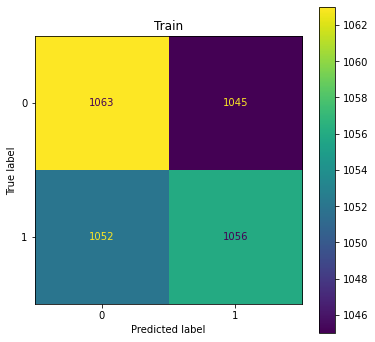

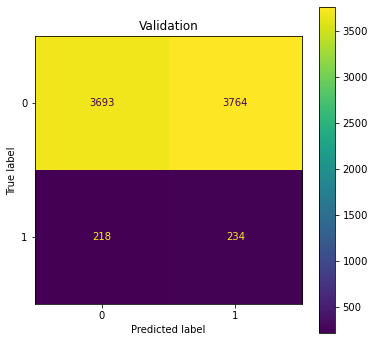

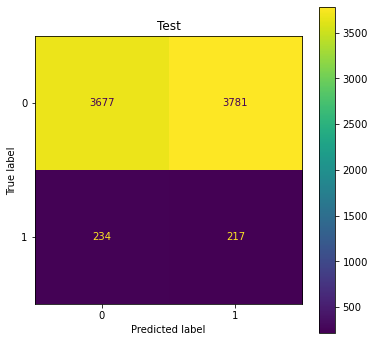

In [36]:
#fit the pipeline and retrieve the scores of train, validation, and test scores
pp1.fit(X_train1, y_train1)

scores(pp1, X_train1, y_train1, 'Train')
scores(pp1, X_val1, y_val1, 'Validation')
scores(pp1, X_test1, y_test1, 'Test')

In [37]:
#instatiate the pipeline with column transformer, PCA, and dummy classifier model
#second dataframe
pp2 = Pipeline(steps=[
    ('c_trans', c_transform2),
    ('pca', PCA(n_components=max_feats_2, random_state=42)),
    ('dummy', DummyClassifier(random_state=42, strategy="stratified")) 
    ])

Train Scores
accuracy:  0.5026091081593927
recall:    0.5009487666034156
Validation Scores
accuracy:  0.4965229485396384
recall:    0.5176991150442478
Test Scores
accuracy:  0.49235048678720444
recall:    0.4811529933481153


(49.2, 48.1)

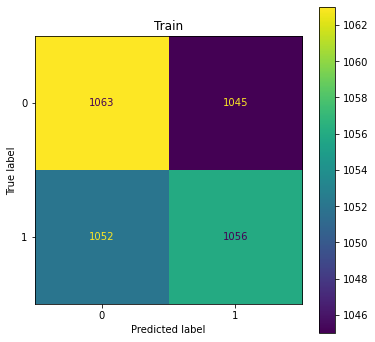

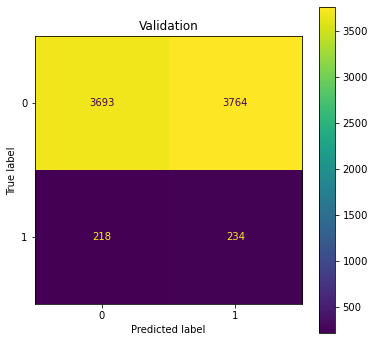

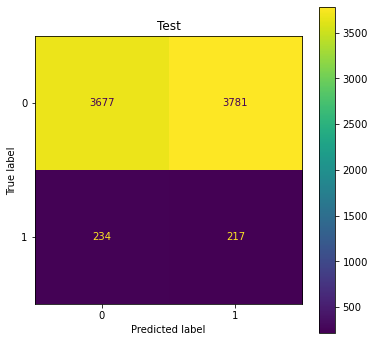

In [38]:
#fit the pipeline and retrieve the scores of train, validation, and test scores
pp2.fit(X_train2, y_train2)

scores(pp2, X_train2, y_train2, 'Train')
scores(pp2, X_val2, y_val2, 'Validation')
scores(pp2, X_test2, y_test2, 'Test')

For the dummy classifier, both the dataframe one and two performed the same. I cannot determine yet which one is better, the predicted classes or predicted probabilities.

### Model 1: Logistic Regression

#### Dataframe 1

In [39]:
#instatiate the pipeline with column transformer, PCA, and logistic regression model
#first dataframe
pp1 = Pipeline(steps=[
    ('c_trans', c_transform1),
    ('pca', PCA(n_components=max_feats_1, random_state=42)),
    ('logreg', LogisticRegression(random_state=42)) 
    ])

Train Scores
accuracy:  0.7203510436432637
recall:    0.7604364326375711
Validation Scores
accuracy:  0.6404096598811481
recall:    0.7212389380530974
Test Scores
accuracy:  0.6387659628271589
recall:    0.7095343680709535


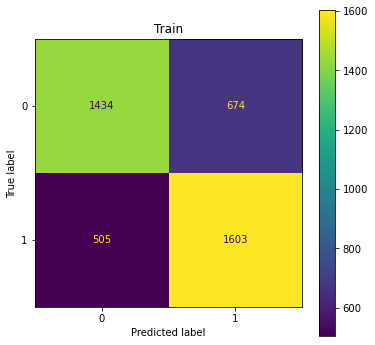

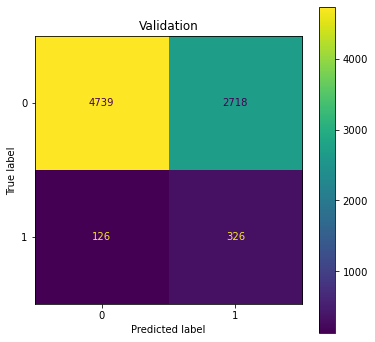

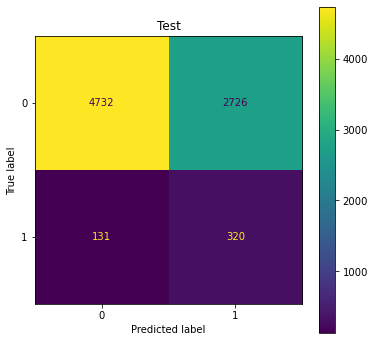

In [40]:
#fit the pipeline and retrieve the scores of train, validation, and test scores
pp1.fit(X_train1, y_train1)

scores(pp1, X_train1, y_train1, 'Train')
scores(pp1, X_val1, y_val1, 'Validation')
log_acc1, log_recall1 = scores(pp1, X_test1, y_test1, 'Test')

#### Dataframe 2

In [41]:
#instatiate the pipeline with column transformer, PCA, and logistic regression model
#second dataframe
pp2 = Pipeline(steps=[
    ('c_trans', c_transform2),
    ('pca', PCA(n_components=max_feats_2, random_state=42)),
    ('logreg', LogisticRegression(random_state=42)) 
    ])

Train Scores
accuracy:  0.7286527514231499
recall:    0.7604364326375711
Validation Scores
accuracy:  0.6605133392337843
recall:    0.7190265486725663
Test Scores
accuracy:  0.66139840687824
recall:    0.7028824833702882


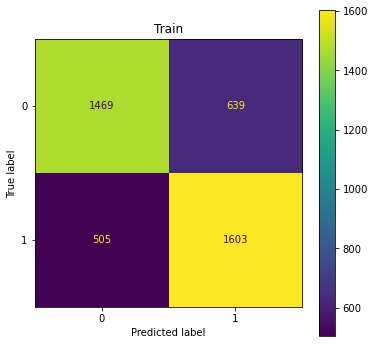

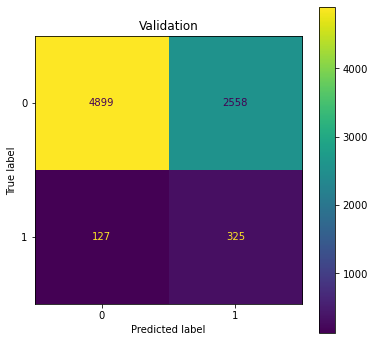

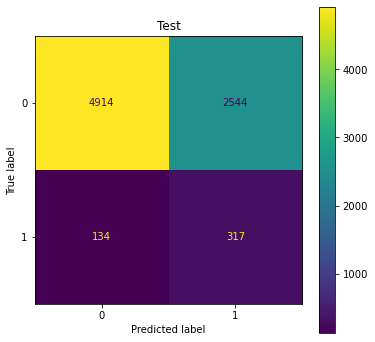

In [42]:
#fit the pipeline and retrieve the scores of train, validation, and test scores
pp2.fit(X_train2, y_train2)

scores(pp2, X_train2, y_train2, 'Train')
scores(pp2, X_val2, y_val2, 'Validation')
log_acc2, log_recall2 = scores(pp2, X_test2, y_test2, 'Test')

The dataframe with the predicted probabilities had the better test scores than dataframe with the predicted classes. However, this may only be for this model. Therefore, I will test both sets of dataframes for all models going forward.

### Model 2: Gaussian Naive Bayes

#### Dataframe 1

In [43]:
#instatiate the pipeline with column transformer, PCA, and gaussian Naive Bayes model
pp_gnb1 = Pipeline(steps=[
    ('c_trans', c_transform1),
    ('pca', PCA(n_components=max_feats_1, random_state=42)),
    ('gnb', GaussianNB()) 
    ])

Train Scores
accuracy:  0.6392314990512334
recall:    0.7063567362428842
Validation Scores
accuracy:  0.5105575926160071
recall:    0.6858407079646017
Test Scores
accuracy:  0.5153622455430522
recall:    0.6784922394678492


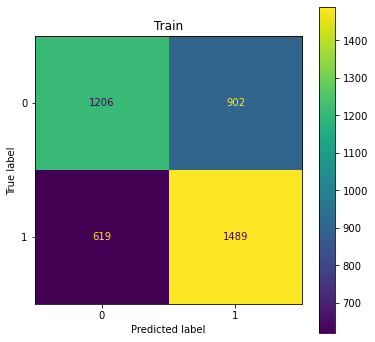

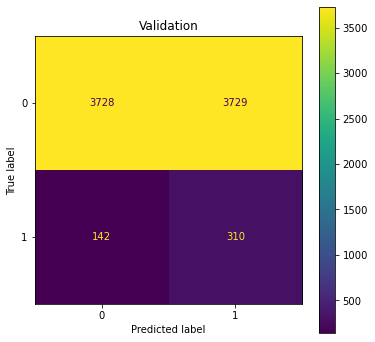

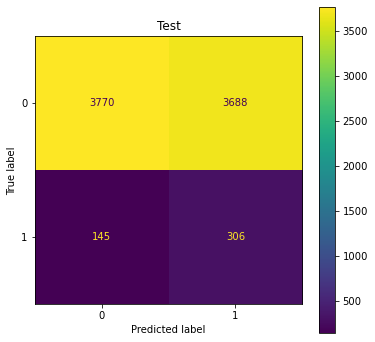

In [44]:
#fit the pipeline and retrieve the scores of train, validation, and test scores
pp_gnb1.fit(X_train1, y_train1)

scores(pp_gnb1, X_train1, y_train1, 'Train')
scores(pp_gnb1, X_val1, y_val1, 'Validation')
gnb_acc1, gnb_recall1 = scores(pp_gnb1, X_test1, y_test1, 'Test')

#### Dataframe 2

In [45]:
#instatiate the pipeline with column transformer, PCA, and gaussian Naive Bayes model
pp_gnb2 = Pipeline(steps=[
    ('c_trans', c_transform2),
    ('pca', PCA(n_components=max_feats_1, random_state=42)),
    ('gnb', GaussianNB()) 
    ])

Train Scores
accuracy:  0.639943074003795
recall:    0.7058823529411765
Validation Scores
accuracy:  0.5129599190795296
recall:    0.6858407079646017
Test Scores
accuracy:  0.518396763181186
recall:    0.6807095343680709


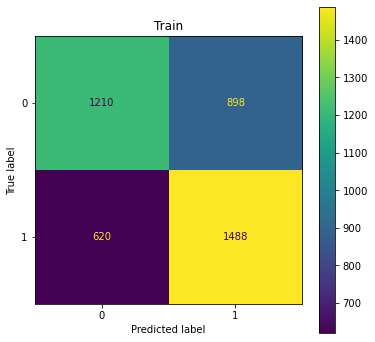

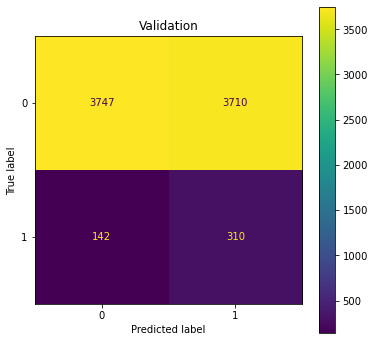

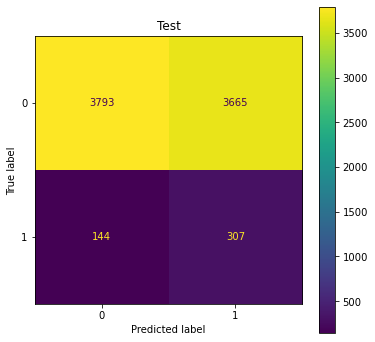

In [46]:
#fit the pipeline and retrieve the scores of train, validation, and test scores
pp_gnb2.fit(X_train1, y_train1)

scores(pp_gnb2, X_train1, y_train1, 'Train')
scores(pp_gnb2, X_val1, y_val1, 'Validation')
gnb_acc2, gnb_recall2 = scores(pp_gnb2, X_test1, y_test1, 'Test')

### Model 3: Random Forest

#### Dataframe 1

In [47]:
#instatiate the pipeline with column transformer, PCA, and Random Forest model
pp_rf = Pipeline(steps=[
    ('c_trans', c_transform1),
    ('pca', PCA(n_components=max_feats_1, random_state=42)),
    ('rf', RandomForestClassifier(random_state=42)) 
    ])

In [48]:
grid = {'rf__max_depth': [3,5,8,10],
        'rf__max_features': ['auto', 'sqrt'],
        'rf__min_samples_leaf': [2, 5, 10],
        'rf__min_samples_split': [2, 5, 7]}

In [49]:
#grid search
gs_rf = GridSearchCV(estimator=pp_rf, 
                      param_grid=grid, 
                      scoring='recall', 
                      cv=3,
                      verbose=2,
                      n_jobs=-1
                     )

I ran the grid search but commented out the code so that it did not have to run everytime I reran the notebook. I saved the results below.

In [50]:
# gs_rf.fit(X_train1, y_train1)

# scores(gs_rf, X_train1, y_train1, 'Train')
# scores(gs_rf, X_val1, y_val1, 'Validation')
# rf_acc, rf_recall = scores(gs_rf, X_test1, y_test1, 'Test')

In [51]:
# gs_rf.best_params_

In [52]:
"""
{'rf__max_depth': 5,
 'rf__max_features': 'auto',
 'rf__min_samples_leaf': 5,
 'rf__min_samples_split': 2}
"""

"\n{'rf__max_depth': 5,\n 'rf__max_features': 'auto',\n 'rf__min_samples_leaf': 5,\n 'rf__min_samples_split': 2}\n"

In [53]:
#instatiate the pipeline with column transformer, PCA, and Random Forest model, with metrics from
#the grid search
pp_rf1 = Pipeline(steps=[('c_trans', c_transform1),
                        ('pca', PCA(n_components=max_feats_1, random_state=42)),
                        ('rf', RandomForestClassifier(random_state=42,
                                                      max_depth=5,
                                                      max_features='auto',
                                                      min_samples_leaf=5,
                                                      min_samples_split=2)) 
    ])

Train Scores
accuracy:  0.7784629981024668
recall:    0.829696394686907
Validation Scores
accuracy:  0.6254899481603237
recall:    0.7168141592920354
Test Scores
accuracy:  0.6378808951827033
recall:    0.7560975609756098


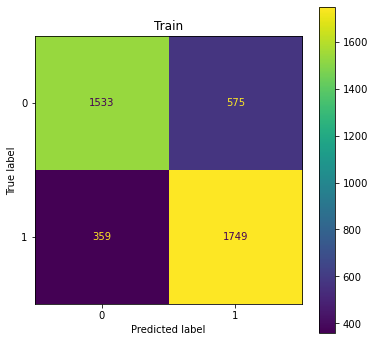

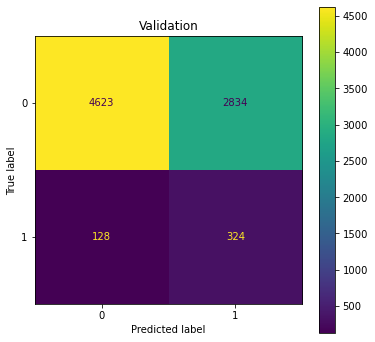

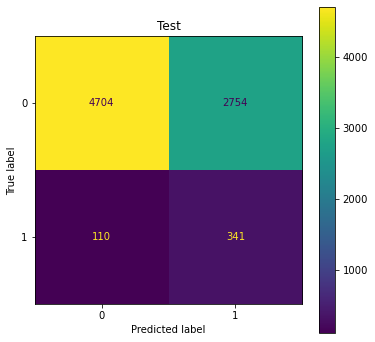

In [54]:
#fit the pipeline and retrieve the scores of train, validation, and test scores
pp_rf1.fit(X_train1, y_train1)

scores(pp_rf1, X_train1, y_train1, 'Train')
scores(pp_rf1, X_val1, y_val1, 'Validation')
figure_test, rf_acc1, rf_recall1 = scores(pp_rf1, X_test1, y_test1, 'Test', return_conf=True)
figure_test.savefig('images/Model_Set2_Test_CF.png', bbox_inches='tight')

#### Dataframe 2

In [55]:
#instatiate the pipeline with column transformer, PCA, and Random Forest model
pp_rf = Pipeline(steps=[
    ('c_trans', c_transform2),
    ('pca', PCA(n_components=max_feats_2, random_state=42)),
    ('rf', RandomForestClassifier(random_state=42)) 
    ])

In [56]:
grid = {'rf__max_depth': [3,5,8,10],
        'rf__max_features': ['auto', 'sqrt'],
        'rf__min_samples_leaf': [2, 5, 10],
        'rf__min_samples_split': [2, 5, 7]}

In [57]:
#grid search
gs_rf = GridSearchCV(estimator=pp_rf, 
                      param_grid=grid, 
                      scoring='recall', 
                      cv=3,
                      verbose=2,
                      n_jobs=-1
                     )

I ran the grid search but commented out the code so that it did not have to run everytime I reran the notebook. I saved the results below.

In [58]:
# gs_rf.fit(X_train2, y_train2)

# scores(gs_rf, X_train2, y_train2, 'Train')
# scores(gs_rf, X_val2, y_val2, 'Validation')
# rf_acc2, rf_recall2 = scores(gs_rf, X_test2, y_test2, 'Test')

In [59]:
# gs_rf.best_params_

In [60]:
"""
{'rf__max_depth': 5,
 'rf__max_features': 'auto',
 'rf__min_samples_leaf': 2,
 'rf__min_samples_split': 7}
"""

"\n{'rf__max_depth': 5,\n 'rf__max_features': 'auto',\n 'rf__min_samples_leaf': 2,\n 'rf__min_samples_split': 7}\n"

In [61]:
#instatiate the pipeline with column transformer, PCA, and Random Forest model, with metrics from
#the grid search
pp_rf2 = Pipeline(steps=[('c_trans', c_transform2),
                        ('pca', PCA(n_components=max_feats_2, random_state=42)),
                        ('rf', RandomForestClassifier(random_state=42,
                                                      max_depth=5,
                                                      max_features='auto',
                                                      min_samples_leaf=2,
                                                      min_samples_split=7)) 
    ])

Train Scores
accuracy:  0.7948292220113852
recall:    0.8311195445920304
Validation Scores
accuracy:  0.6483752686812492
recall:    0.7168141592920354
Test Scores
accuracy:  0.6565937539511948
recall:    0.7228381374722838


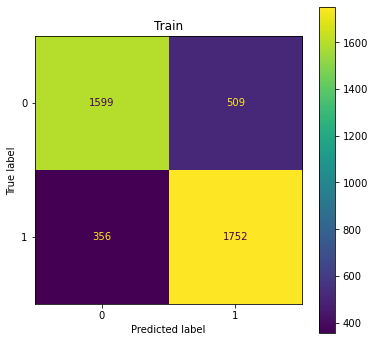

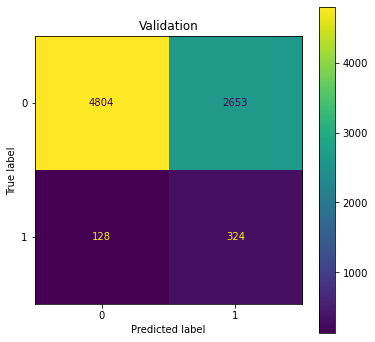

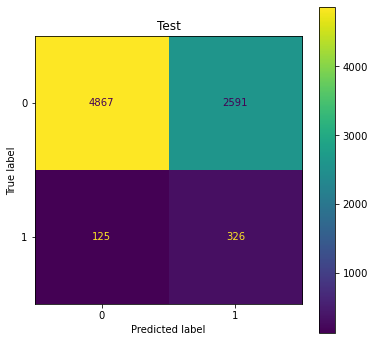

In [62]:
#fit the pipeline and retrieve the scores of train, validation, and test scores
pp_rf2.fit(X_train2, y_train2)

scores(pp_rf2, X_train2, y_train2, 'Train')
scores(pp_rf2, X_val2, y_val2, 'Validation')
rf_acc2, rf_recall2 = scores(pp_rf2, X_test2, y_test2, 'Test')

### Model 4: K-Nearest Neighbors

#### Dataframe 1

In [63]:
#instatiate the pipeline with column transformer, PCA, and KNN model
pp_knn = Pipeline(steps=[
    ('c_trans', c_transform1),
    ('pca', PCA(n_components=max_feats_1, random_state=42)),
    ('knn', KNeighborsClassifier(weights='uniform'))  
    ])

In [64]:
grid = {'knn__n_neighbors': list(range(3, 44, 5)),
        'knn__p': [1, 2, 3, 4]}

In [65]:
#grid search
gs_knn = GridSearchCV(estimator=pp_knn, 
                      param_grid=grid, 
                      scoring='recall', 
                      cv=3,
                      verbose=2,
                      n_jobs=-1
                     )

I ran the grid search but commented out the code so that it did not have to run everytime I reran the notebook. I saved the results below.

In [66]:
# gs_knn.fit(X_train1, y_train1)

# scores(gs_knn, X_train1, y_train1, 'Train')
# scores(gs_knn, X_val1, y_val1, 'Validation')
# knn_acc, knn_recall = scores(gs_knn, X_test1, y_test1, 'Test')

In [67]:
# gs_knn.best_params_

In [68]:
'''
{'knn__n_neighbors': 43, 'knn__p': 1}
'''

"\n{'knn__n_neighbors': 43, 'knn__p': 1}\n"

In [69]:
#instatiate the pipeline with column transformer, PCA, and KNN model, with metrics from
#the grid search
pp_knn1 = Pipeline(steps=[('c_trans', c_transform1),
                         ('pca', PCA(n_components=max_feats_1, random_state=42)),
                         ('knn', KNeighborsClassifier(n_neighbors=53, #increasing n_neighbors mitigate overfitting
                                                      p=1,
                                                      weights='uniform')) #adjusting the weights to uniform instead of distance helped with the overfitting 
     ])

Train Scores
accuracy:  0.6826375711574952
recall:    0.7879506641366224
Validation Scores
accuracy:  0.565684663042104
recall:    0.7389380530973452
Test Scores
accuracy:  0.5776962953597168
recall:    0.7694013303769401


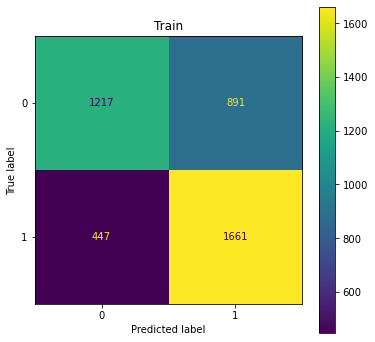

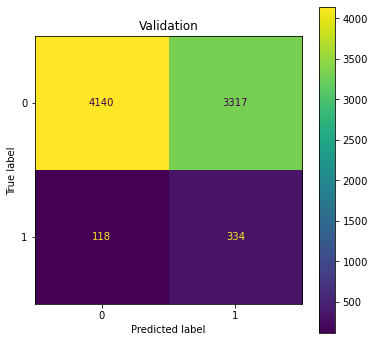

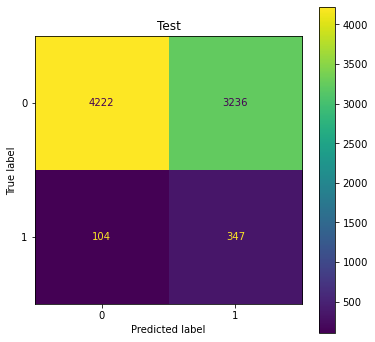

In [70]:
#fit the pipeline and retrieve the scores of train, validation, and test scores
pp_knn1.fit(X_train1, y_train1)

scores(pp_knn1, X_train1, y_train1, 'Train')
scores(pp_knn1, X_val1, y_val1, 'Validation')
knn_acc1, knn_recall1 = scores(pp_knn1, X_test1, y_test1, 'Test')

#### Dataframe 2

In [71]:
#instatiate the pipeline with column transformer, PCA, and KNN model
pp_knn = Pipeline(steps=[
    ('c_trans', c_transform2),
    ('pca', PCA(n_components=max_feats_2, random_state=42)),
    ('knn', KNeighborsClassifier(weights='uniform'))  
    ])

In [72]:
grid = {'knn__n_neighbors': list(range(3, 44, 5)),
        'knn__p': [1, 2, 3, 4]}

In [73]:
#grid search
gs_knn = GridSearchCV(estimator=pp_knn, 
                      param_grid=grid, 
                      scoring='recall', 
                      cv=3,
                      verbose=2,
                      n_jobs=-1
                     )

I ran the grid search but commented out the code so that it did not have to run everytime I reran the notebook. I saved the results below.

In [74]:
# gs_knn.fit(X_train2, y_train2)

# scores(gs_knn, X_train2, y_train2, 'Train')
# scores(gs_knn, X_val2, y_val2, 'Validation')
# knn_acc, knn_recall = scores(gs_knn, X_test2, y_test2, 'Test')

In [75]:
# gs_knn.best_params_

In [76]:
"""
{'knn__n_neighbors': 43, 'knn__p': 2}
"""

"\n{'knn__n_neighbors': 43, 'knn__p': 2}\n"

In [77]:
#instatiate the pipeline with column transformer, PCA, and KNN model, with metrics from
#the grid search
pp_knn2 = Pipeline(steps=[('c_trans', c_transform2),
                         ('pca', PCA(n_components=max_feats_2, random_state=42)),
                         ('knn', KNeighborsClassifier(n_neighbors=43,
                                                      p=2,
                                                      weights='uniform')) #adjusting the weights to uniform instead of distance helped with the overfitting 
     ])

Train Scores
accuracy:  0.6994781783681214
recall:    0.7628083491461101
Validation Scores
accuracy:  0.6218232393475787
recall:    0.7588495575221239
Test Scores
accuracy:  0.6268807687444683
recall:    0.7516629711751663


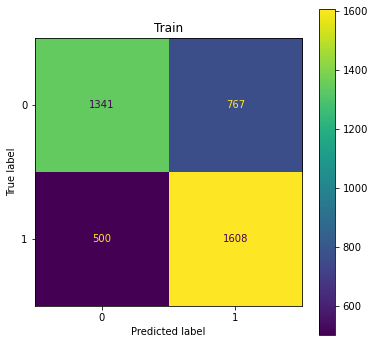

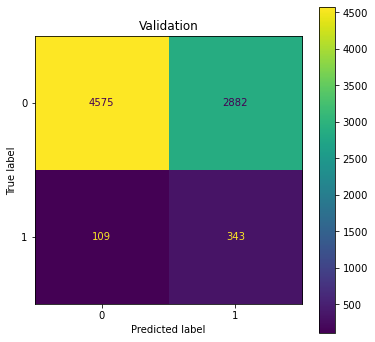

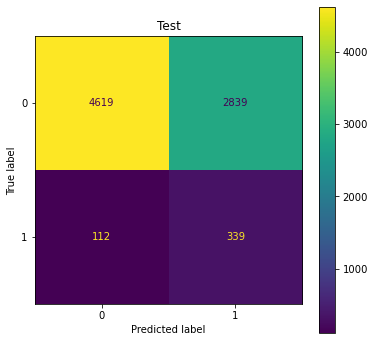

In [78]:
#fit the pipeline and retrieve the scores of train, validation, and test scores
pp_knn2.fit(X_train2, y_train2)

scores(pp_knn2, X_train2, y_train2, 'Train')
scores(pp_knn2, X_val2, y_val2, 'Validation')
knn_acc2, knn_recall2 = scores(pp_knn2, X_test2, y_test2, 'Test')

### Model 5: Decision Tree Model

#### Dataframe 1

In [79]:
#instatiate the pipeline with column transformer, PCA, and Decision Tree model
pp_dt = Pipeline(steps=[
    ('c_trans', c_transform1),
    ('pca', PCA(n_components=max_feats_1, random_state=42)),
    ('dt', DecisionTreeClassifier(random_state=42))  
    ])

In [80]:
grid = {'dt__criterion': ['gini', 'entropy'],
        'dt__max_depth': np.arange(1,17, 3),
        'dt__min_samples_split': np.arange(20, 101, 20),
        'dt__min_samples_leaf': np.arange(20, 101,20)
       }

In [81]:
#grid search
gs_dt = GridSearchCV(estimator=pp_dt, 
                      param_grid=grid, 
                      scoring='recall',
                      cv=3,
                      verbose=2,
                      n_jobs=-1
                     )

I ran the grid search but commented out the code so that it did not have to run everytime I reran the notebook. I saved the results below.

In [82]:
# gs_dt.fit(X_train1, y_train1)

# scores(gs_dt, X_train1, y_train1, 'Train')
# scores(gs_dt, X_val1, y_val1, 'Validation')
# dt_acc, dt_recall = scores(gs_dt, X_test1, y_test1, 'Test')

In [83]:
# gs_dt.best_params_

In [84]:
"""
{'dt__criterion': 'gini',
 'dt__max_depth': 1,
 'dt__min_samples_leaf': 20,
 'dt__min_samples_split': 20}
"""

"\n{'dt__criterion': 'gini',\n 'dt__max_depth': 1,\n 'dt__min_samples_leaf': 20,\n 'dt__min_samples_split': 20}\n"

In [85]:
#instatiate the pipeline with column transformer, PCA, and Decision Tree model, with metrics from
#the grid search
pp_dt1 = Pipeline(steps=[('c_trans', c_transform1),
                        ('pca', PCA(n_components=max_feats_1, random_state=42)),
                        ('dt', DecisionTreeClassifier(random_state=42,
                                                      criterion='gini',
                                                      max_depth=1,
                                                      min_samples_leaf=20,
                                                      min_samples_split=20)) 
    ])

Train Scores
accuracy:  0.6131404174573055
recall:    0.7077798861480076
Validation Scores
accuracy:  0.5234542925780756
recall:    0.668141592920354
Test Scores
accuracy:  0.534707295486155
recall:    0.7095343680709535


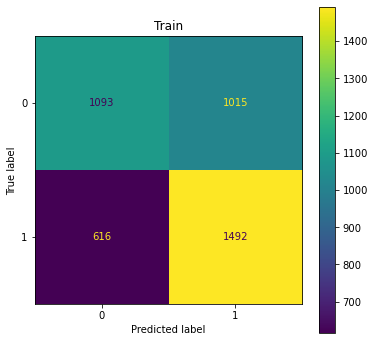

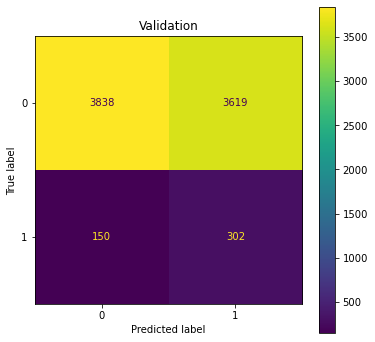

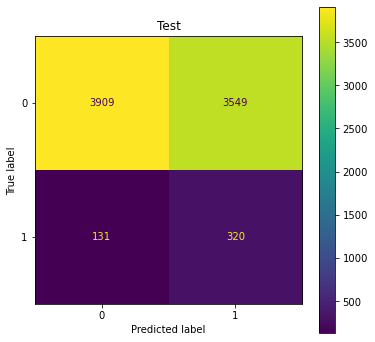

In [86]:
#fit the pipeline and retrieve the scores of train, validation, and test scores
pp_dt1.fit(X_train1, y_train1)

scores(pp_dt1, X_train1, y_train1, 'Train')
scores(pp_dt1, X_val1, y_val1, 'Validation')
dt_acc1, dt_recall1 = scores(pp_dt1, X_test1, y_test1, 'Test')

#### Dataframe 2

In [87]:
#instatiate the pipeline with column transformer, PCA, and Decision Tree model
pp_dt = Pipeline(steps=[
    ('c_trans', c_transform2),
    ('pca', PCA(n_components=max_feats_2, random_state=42)),
    ('dt', DecisionTreeClassifier(random_state=42))  
    ])

In [88]:
grid = {'dt__criterion': ['gini', 'entropy'],
        'dt__max_depth': np.arange(1,17, 3),
        'dt__min_samples_split': np.arange(20, 101, 20),
        'dt__min_samples_leaf': np.arange(20, 101,20)
       }

In [89]:
#grid search
gs_dt = GridSearchCV(estimator=pp_dt, 
                      param_grid=grid, 
                      scoring='recall',
                      cv=3,
                      verbose=2,
                      n_jobs=-1
                     )

I ran the grid search but commented out the code so that it did not have to run everytime I reran the notebook. I saved the results below.

In [90]:
# gs_dt.fit(X_train2, y_train2)

# scores(gs_dt, X_train2, y_train2, 'Train')
# scores(gs_dt, X_val2, y_val2, 'Validation')
# dt_acc, dt_recall = scores(gs_dt, X_test2, y_test2, 'Test')

In [91]:
# gs_dt.best_params_

In [92]:
"""
{'dt__criterion': 'entropy',
 'dt__max_depth': 7,
 'dt__min_samples_leaf': 60,
 'dt__min_samples_split': 20}
"""

"\n{'dt__criterion': 'entropy',\n 'dt__max_depth': 7,\n 'dt__min_samples_leaf': 60,\n 'dt__min_samples_split': 20}\n"

In [93]:
#instatiate the pipeline with column transformer, PCA, and Decision Tree model, with metrics from
#the grid search
pp_dt2 = Pipeline(steps=[('c_trans', c_transform2),
                        ('pca', PCA(n_components=max_feats_2, random_state=42)),
                        ('dt', DecisionTreeClassifier(random_state=42,
                                                      criterion='entropy',
                                                      max_depth=7,
                                                      min_samples_leaf=60,
                                                      min_samples_split=20)) 
    ])

Train Scores
accuracy:  0.62926944971537
recall:    0.7125237191650854
Validation Scores
accuracy:  0.5130863573144518
recall:    0.6637168141592921
Test Scores
accuracy:  0.5195347072954861
recall:    0.7184035476718403


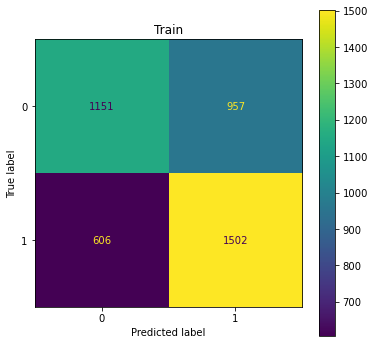

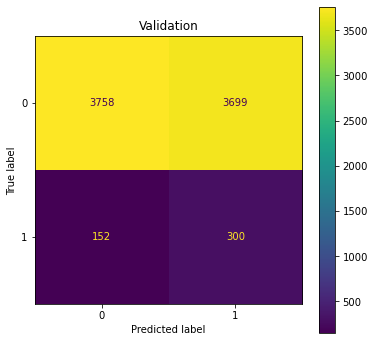

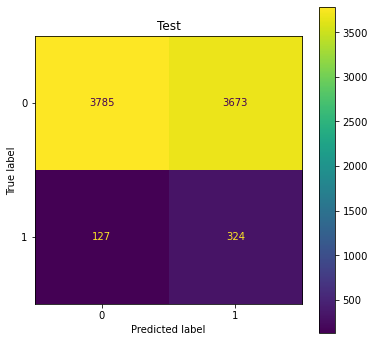

In [94]:
#fit the pipeline and retrieve the scores of train, validation, and test scores
pp_dt2.fit(X_train1, y_train1)

scores(pp_dt2, X_train2, y_train2, 'Train')
scores(pp_dt2, X_val2, y_val2, 'Validation')
dt_acc2, dt_recall2 = scores(pp_dt2, X_test2, y_test2, 'Test')

### Model 6: Gradient Boost

#### Dataframe 1

In [95]:
#instatiate the pipeline with column transformer, PCA, and Gradient Boost model
pp_gbc = Pipeline(steps=[
    ('c_trans', c_transform1),
    ('pca', PCA(n_components=max_feats_1, random_state=42)),
    ('gbc', GradientBoostingClassifier(random_state=42))  
    ])

In [96]:
grid = {'gbc__max_depth': np.arange(1,18, 4),
        'gbc__min_samples_split': np.arange(20, 101, 20),
        'gbc__min_samples_leaf': np.arange(20, 101,20)
       }

In [97]:
#grid search
gs_gbc = GridSearchCV(estimator=pp_gbc, 
                      param_grid=grid, 
                      scoring='recall', 
                      cv=3,
                      verbose=2,
                      n_jobs=-1
                     )

I ran the grid search but commented out the code so that it did not have to run everytime I reran the notebook. I saved the results below.

In [98]:
# gs_gbc.fit(X_train1, y_train1)

# scores(gs_gbc, X_train1, y_train1, 'Train')
# scores(gs_gbc, X_val1, y_val1, 'Validation')
# gbc_acc, gbc_recall = scores(gs_gbc, X_test1, y_test1, 'Test')

In [99]:
# gs_gbc.best_params_

In [100]:
"""
{'gbc__max_depth': 1,
 'gbc__min_samples_leaf': 100,
 'gbc__min_samples_split': 20}
"""

"\n{'gbc__max_depth': 1,\n 'gbc__min_samples_leaf': 100,\n 'gbc__min_samples_split': 20}\n"

In [101]:
#instatiate the pipeline with column transformer, PCA, and Gradient Boost model, with metrics from
#the grid search
pp_gbc1 = Pipeline(steps=[('c_trans', c_transform1),
                         ('pca', PCA(n_components=max_feats_1, random_state=42)),
                         ('gbc', GradientBoostingClassifier(random_state=42,
                                                            max_features='auto',
                                                            max_depth=1,
                                                            min_samples_leaf=100,
                                                            min_samples_split=20))
    ])

Train Scores
accuracy:  0.6847722960151803
recall:    0.7186907020872866
Validation Scores
accuracy:  0.6421797951700594
recall:    0.6570796460176991
Test Scores
accuracy:  0.6452143128081932
recall:    0.6984478935698448


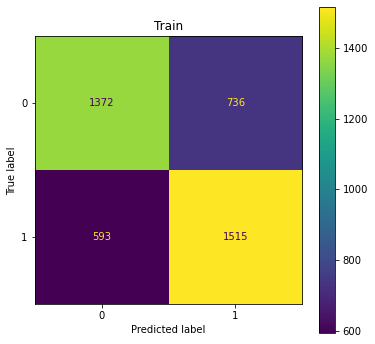

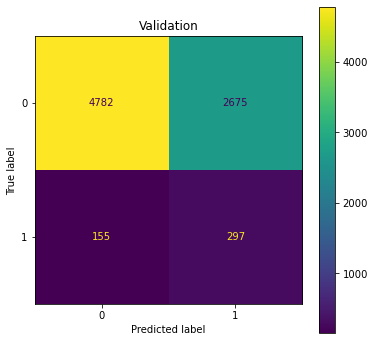

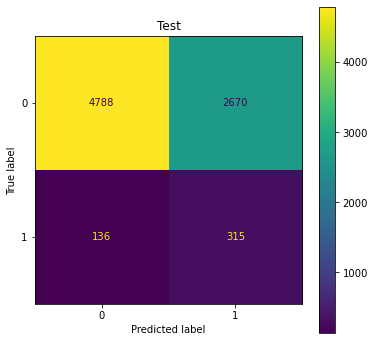

In [102]:
#fit the pipeline and retrieve the scores of train, validation, and test scores
pp_gbc1.fit(X_train1, y_train1)

scores(pp_gbc1, X_train1, y_train1, 'Train')
scores(pp_gbc1, X_val1, y_val1, 'Validation')
gbc_acc1, gbc_recall1 = scores(pp_gbc1, X_test1, y_test1, 'Test')

#### Dataframe 2

In [103]:
#instatiate the pipeline with column transformer, PCA, and Gradient Boost model
pp_gbc = Pipeline(steps=[
    ('c_trans', c_transform2),
    ('pca', PCA(n_components=max_feats_2, random_state=42)),
    ('gbc', GradientBoostingClassifier(random_state=42))  
    ])

In [104]:
grid = {'gbc__max_depth': np.arange(1,18, 4),
        'gbc__min_samples_split': np.arange(20, 101, 20),
        'gbc__min_samples_leaf': np.arange(20, 101,20)
       }

In [105]:
#grid search
gs_gbc = GridSearchCV(estimator=pp_gbc, 
                      param_grid=grid, 
                      scoring='recall', 
                      cv=3,
                      verbose=2,
                      n_jobs=-1
                     )

I ran the grid search but commented out the code so that it did not have to run everytime I reran the notebook. I saved the results below.

In [106]:
# gs_gbc.fit(X_train2, y_train2)

# scores(gs_gbc, X_train2, y_train2, 'Train')
# scores(gs_gbc, X_val2, y_val2, 'Validation')
# gbc_acc, gbc_recall = scores(gs_gbc, X_test2, y_test2, 'Test')

In [107]:
# gs_gbc.best_params_

In [108]:
"""
{'gbc__max_depth': 13,
 'gbc__min_samples_leaf': 20,
 'gbc__min_samples_split': 20}
"""

"\n{'gbc__max_depth': 13,\n 'gbc__min_samples_leaf': 20,\n 'gbc__min_samples_split': 20}\n"

In [109]:
#instatiate the pipeline with column transformer, PCA, and Gradient Boost model, with metrics from
#the grid search
pp_gbc2 = Pipeline(steps=[('c_trans', c_transform2),
                         ('pca', PCA(n_components=max_feats_2, random_state=42)),
                          #I further adjusted to reduce overfitting
                         ('gbc', GradientBoostingClassifier(random_state=42,
                                                            max_features='auto',
                                                            max_depth=3,
                                                            min_samples_leaf=20,
                                                            min_samples_split=20))
    ])

Train Scores
accuracy:  0.801944971537002
recall:    0.8225806451612904
Validation Scores
accuracy:  0.6668352509798963
recall:    0.6814159292035398
Test Scores
accuracy:  0.6710077127323303
recall:    0.7006651884700665


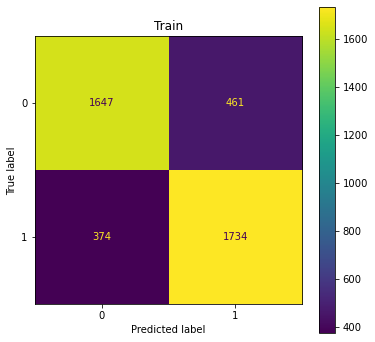

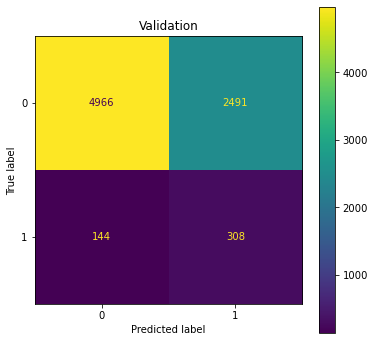

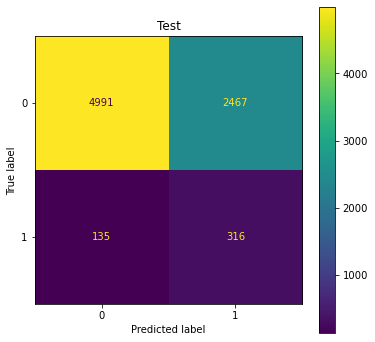

In [110]:
#fit the pipeline and retrieve the scores of train, validation, and test scores
pp_gbc2.fit(X_train2, y_train2)

scores(pp_gbc2, X_train2, y_train2, 'Train')
scores(pp_gbc2, X_val2, y_val2, 'Validation')
gbc_acc2, gbc_recall2 = scores(pp_gbc2, X_test2, y_test2, 'Test')

### Model 7: Ensemble

#### Dataframe 1

In [111]:
#instatiate the pipeline with column transformer, PCA, and logression regression model
pp_logreg1 = Pipeline(steps=[
    ('c_trans', c_transform1),
    ('pca', PCA(n_components=max_feats_1, random_state=42)),
    ('logreg', LogisticRegression(random_state=42))  
    ])

In [112]:
#instatiate the voting classfier using the several models from above
voting_clf1 = VotingClassifier(estimators={("logreg", pp_logreg1),
                                          #("gnb", pp_gnb1), #commented out to improve scores
                                          ("rf", pp_rf1),
                                          ('knn', pp_knn1),
                                          #('dt', pp_dt1), #commented out to improve scores
                                          ("gbc", pp_gbc1)
                                        },
                              voting= "soft")

Train Scores
accuracy:  0.7186907020872866
recall:    0.7741935483870968
Validation Scores
accuracy:  0.6329498040207359
recall:    0.7234513274336283
Test Scores
accuracy:  0.6402832216462259
recall:    0.7339246119733924


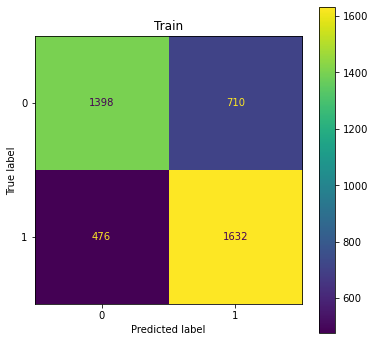

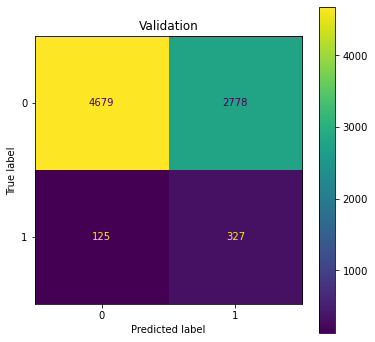

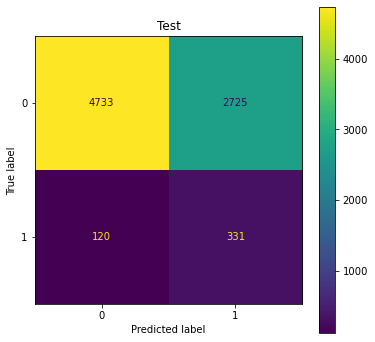

In [113]:
#fit the pipeline and retrieve the scores of train, validation, and test scores
voting_clf1.fit(X_train1, y_train1)

scores(voting_clf1, X_train1, y_train1, 'Train')
scores(voting_clf1, X_val1, y_val1, 'Validation')
vot_acc1, vot_recall1 = scores(voting_clf1, X_test1, y_test1, 'Test')

#### Dataframe 2

In [114]:
#instatiate the pipeline with column transformer, PCA, and logression regression model
pp_logreg2 = Pipeline(steps=[
    ('c_trans', c_transform2),
    ('pca', PCA(n_components=max_feats_2, random_state=42)),
    ('logreg', LogisticRegression(random_state=42))  
    ])

In [115]:
#instatiate the voting classfier using the several models from above
voting_clf2 = VotingClassifier(estimators={("logreg", pp_logreg2),
                                          ("gnb", pp_gnb2), #commented out to improve scores
                                          ("rf", pp_rf2),
                                          ('knn', pp_knn2),
                                          #('dt', pp_dt2),
                                          ("gbc", pp_gbc2)
                                        },
                              voting= "soft")

Train Scores
accuracy:  0.7395635673624289
recall:    0.784629981024668
Validation Scores
accuracy:  0.6138576305474776
recall:    0.7146017699115044
Test Scores
accuracy:  0.621949677582501
recall:    0.7339246119733924


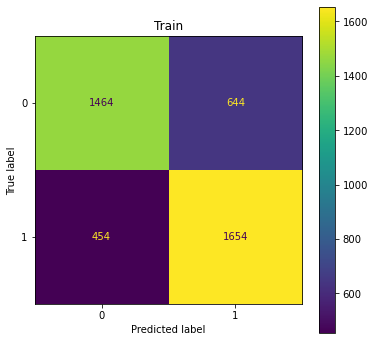

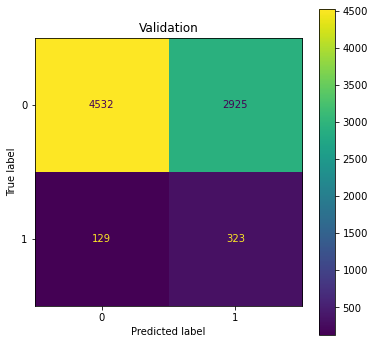

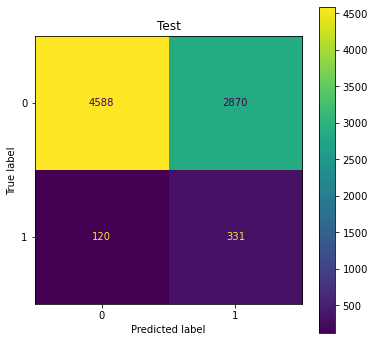

In [116]:
#fit the pipeline and retrieve the scores of train, validation, and test scores
voting_clf2.fit(X_train2, y_train2)

scores(voting_clf2, X_train2, y_train2, 'Train')
scores(voting_clf2, X_val2, y_val2, 'Validation')
vot_acc2, vot_recall2 = scores(voting_clf2, X_test2, y_test2, 'Test')

## Reviewing All Models:

#### Dataframe 1

In [117]:
X_labels = ['Text''\n''Model','Logistic''\n''Regression', 'Gaussian''\n''Naive Bayes', 'Random''\n''Forest', 'KNN', 'Decision''\n''Tree', 'Gradient''\n''Boost', 'Ensemble''\n''(Vote)']
y1 = [70.1, log_recall1, gnb_recall1, rf_recall1, knn_recall1, dt_recall1, gbc_recall1, vot_recall1]

In [118]:
y2 = [62.2, log_acc1, gnb_acc1, rf_acc1, knn_acc1, dt_acc1, gbc_acc1, vot_acc1]

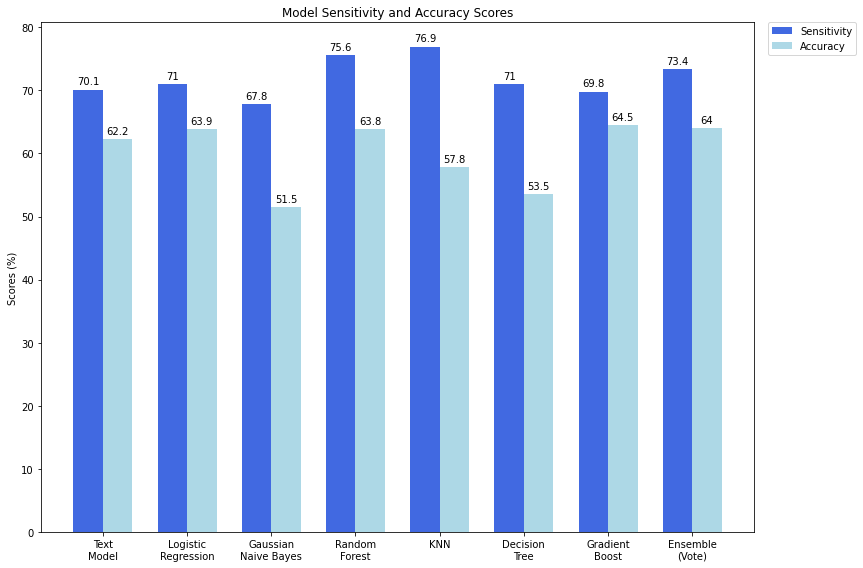

In [119]:
width = 0.35  # the width of the bars
x = np.arange(len(X_labels))
fig, ax = plt.subplots(figsize=(12,8))
rects1 = ax.bar(x - width/2, y1, width, label='Sensitivity', color='royalblue')
rects2 = ax.bar(x + width/2, y2, width, label='Accuracy', color='lightblue')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores (%)')
ax.set_title('Model Sensitivity and Accuracy Scores')
ax.set_xticks(x)
ax.set_xticklabels(X_labels)
ax.legend(bbox_to_anchor=(1.15, 1.01))

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()
#set background color to white
fig.patch.set_facecolor('white')
plt.show()
#save the figure in the images folder
fig.savefig('images/Model_Scores2_1.png', bbox_inches='tight')

After reviewing all the models, it seems that the random forest model performed the best for dataframe 1.

#### Dataframe 2

In [120]:
X_labels = ['Text''\n''Model','Logistic''\n''Regression', 'Gaussian''\n''Naive Bayes', 'Random''\n''Forest', 'KNN', 'Decision''\n''Tree', 'Gradient''\n''Boost', 'Ensemble''\n''(Vote)']
y1 = [70.1, log_recall2, gnb_recall2, rf_recall2, knn_recall2, dt_recall2, gbc_recall2, vot_recall2]

In [121]:
y2 = [62.2, log_acc2, gnb_acc2, rf_acc2, knn_acc2, dt_acc2, gbc_acc2, vot_acc2]

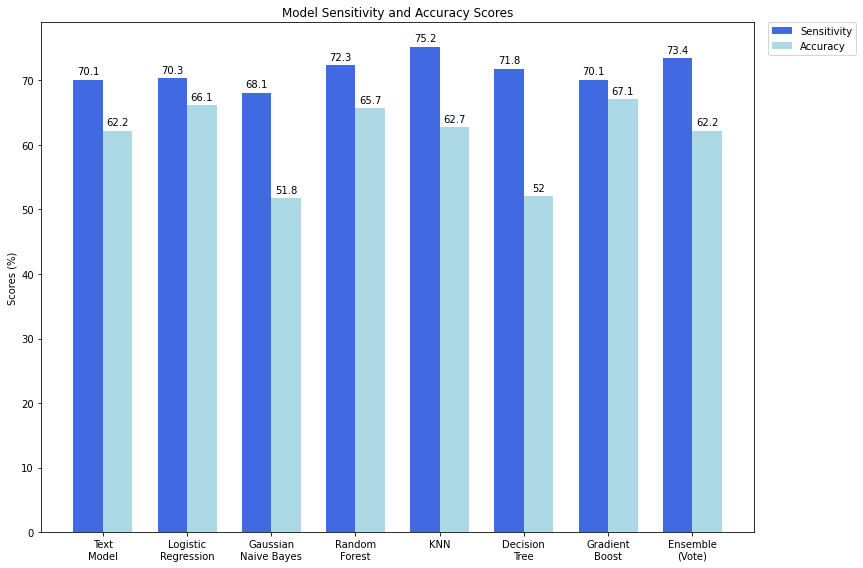

In [122]:
width = 0.35  # the width of the bars
x = np.arange(len(X_labels))
fig, ax = plt.subplots(figsize=(12,8))
rects1 = ax.bar(x - width/2, y1, width, label='Sensitivity', color='royalblue')
rects2 = ax.bar(x + width/2, y2, width, label='Accuracy', color='lightblue')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores (%)')
ax.set_title('Model Sensitivity and Accuracy Scores')
ax.set_xticks(x)
ax.set_xticklabels(X_labels)
ax.legend(bbox_to_anchor=(1.15, 1.01))

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()
#set background color to white
fig.patch.set_facecolor('white')
plt.show()
#save the figure in the images folder
fig.savefig('images/Model_Scores2_2.png', bbox_inches='tight')

After reviewing all the models, it seems that the random forest model performed the best for dataframe 2. However, the random forest model for dataframe 1 had a higher recall score, and therefore I decided that the random forest from dataframe 1 would be the best model.

## Setting Final Model

In [123]:
#split the positive and negative data
df_pos = df1[df1['READMISSION']==1]
df_neg = df1[df1['READMISSION']==0]

In [124]:
#take a sample of the negative training set with the same number of rows as positive dataset
df_neg_samp = df_neg.sample(n=len(df_pos), random_state=42)

In [125]:
#concat the positive dataset and sample of the negative dataset to get one dataset
#with equal number of postiive and negative cases
new_df = pd.concat([df_pos,df_neg_samp],axis=0)

In [126]:
#randomize the new dataset
new_df = new_df.sample(n=len(new_df), random_state=42)

In [127]:
#split out the X and y of the new dataset
new_y = new_df['READMISSION']
new_X = new_df.drop('READMISSION',axis=1)
new_max_feats = int(new_X.shape[0]*0.10)

In [128]:
final_model = pp_rf1

Final Scores
accuracy:  0.7459315841912986
recall:    0.7944204583194951


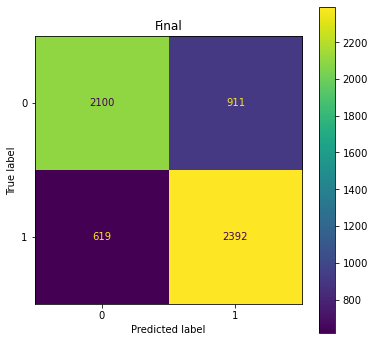

In [129]:
final_model.fit(new_X, new_y)
final_acc, final_recall = scores(final_model, new_X, new_y, 'Final')

## Conclusions and Next Step

The recall (75.6%) and accuracy score (63.8%) of the best model, the random forest model, are lower than ideal. Therefore, I do not recommend ACME health to use this model to classify if patients are likely to be readmitted within 30 days post discharge. Instead, I recommend the following for next steps:
* Obtain additional data outside of the ICU
* Obtain additional data from other health systems
* Implement additional models such as neural networks
* Review other patient data features that can help improve model performance
With more data, I can better fine tune the model to classify correctly which patients are likely to be readmitted.